In [30]:
def visualize(params,line,res,c,q=0):

    cond_probs = np.zeros((len(params.quds), res.size*2))
    for qud_index in range(len(params.quds)):

        subspace_mean,subspace_prior_mean,subspace_variance = params.subspace_means[line][qud_index],params.subspace_prior_means[line][qud_index],params.subspace_variances[line][qud_index]
#         print("prior meannn",subspace_prior_mean)
        vals=scipy.stats.multivariate_normal.pdf((np.arange(-res.size,res.size)*res.amount),mean=subspace_mean,cov=subspace_variance)
        vals/=np.sum(vals)
        cond_probs[qud_index]=vals
        
#         print(scipy.stats.multivariate_normal.pdf([1,2,3],mean=subspace_mean,cov=subspace_variance))
#         print(vals.shape)
#         print(subspace_mean)
#         print("CHECK",np.sum((np.arange(-size,size)*scale+subspace_prior_mean)*vals))

#     print(params.subspace_means.shape)
#     print(params.subspace_means)
#     print("SUBSPACE MEANS",params.subspace_means)
    marginal_mean = np.sum(params.subspace_means[line]*params.qud_marginals)
    print("marginal mean",marginal_mean)
    print("prior mean",subspace_prior_mean)
    marginal = np.sum(cond_probs*np.expand_dims(params.qud_marginals,1),axis=0)
    
    if q is not None:
        print("cond mean",params.subspace_means[line][qud_index])
        print("cond variance",params.subspace_variances[line][qud_index])
        cond = cond_probs[q]
        hm = matplotlib.pyplot.scatter(c=c,x=(np.arange(-res.size,res.size)*res.amount),y=cond)
    
    
#     print("CHECK",np.sum(marginal*(np.arange(-res.size,res.size)*res.amount)))
    else: hm = matplotlib.pyplot.scatter(c=c,x=(np.arange(-res.size,res.size)*res.amount),y=marginal)
#     print("PRIOR MEAN",params.subspace_prior_means[line][0])
#     prior_vals = scipy.stats.multivariate_normal.pdf(np.arange(-res.size,res.size)*res.amount,mean=params.subspace_prior_means[line][0],cov=params.l1_sig1)
#     prior_vals/=np.sum(prior_vals)
#     prior_hm = matplotlib.pyplot.scatter(c='yellow',x=np.arange(-res.size,res.size)*res.amount,y=prior_vals)
    
#     hm_2 = matplotlib.pyplot.scatter(x=(np.arange(-size,size)*scale)+params.subspace_prior_means[line][0],y=marginal)
#     return marginal,marginal_mean,params.subspace_prior_means[line][0]
#     return marginal_means[line]*np.exp(params.qud_marginals)

In [ ]:
from __future__ import division
from collections import defaultdict
import scipy
import numpy as np
import pickle
import itertools
from dist_rsa.dbm import *
from dist_rsa.utils.load_data import *
from dist_rsa.utils.helperfunctions import *
from dist_rsa.utils.config import abstract_threshold,concrete_threshold
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf

# vec_size,vec_kind = 25,'glove.twitter.27B.'
vec_size,vec_kind = 300,'glove.6B.'
# freqs = pickle.load(open('dist_rsa/data/google_freqs/freqs','rb'))
nouns,adjs = get_words(with_freqs=False)
vecs = load_vecs(mean=True,pca=False,vec_length=vec_size,vec_type=vec_kind) 

def l1_model(subj,pred):

    print('abstract_threshold',abstract_threshold)
    print('concrete_threshold',concrete_threshold)

    qud_words = [a for a in list(adjs) if adjs[a] < abstract_threshold and a in vecs]

    quds = sorted(qud_words,\
        key=lambda x:scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[pred],vecs[subj]],axis=0)),reverse=False)
        # key=lambda x:freqs[x],reverse=True)

    noun_words = [n for n in nouns if nouns[n] > concrete_threshold and n in vecs]
    possible_utterances = sorted(noun_words,\
        key=lambda x: scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[subj],vecs[subj]],axis=0)),reverse=False)
        # key=lambda x:freqs[x],reverse=True)


    for x in possible_utterances:
        if x not in vecs:
            # print(x,"not in vecs")
            possible_utterances.remove(x)
            # raise Exception("utterance not in vecs")

    quds = sorted(quds[:50])
    possible_utterances = possible_utterances[:200]

    print("QUDS",quds[:10]) 
    print("UTTERANCES:\n",possible_utterances[:10])


    params = Inference_Params(
        vecs=vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=list(set(possible_utterances).union(set([pred]))),
        sig1=20.0,sig2=0.1,l1_sig1=20.0,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=True,
        heatmap=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_mixture",
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)


    out = run.tf_results
    tf.reset_default_graph()
    return out,params

    # world_means = run.world_samples
    # print(world_means[:5],"MEANS")

    # print(results[:5])

    # if not is_baseline:
    #     worldm = run.world_movement("cosine",comparanda=[x for x in qud_words if x in vecs])
    #     # print("\nworld\n",worldm[:5])
    # else: worldm = None
        # out.write("\nWORLD MOVEMENT:\n")
        # out.write(str(worldm))
    # print("WORLD MOVEMENT WITH PROJECTION\n:",run.world_movement("cosine",comparanda=[x for x in quds if x in vecs],do_projection=True)[:50])
    # print("BASELINE:\n",sorted(qud_words,\
    #     key=lambda x:scipy.spatial.distance.cosine(vecs[x],np.mean([vecs[subj],vecs[pred]],axis=0)),reverse=False)[:5])

    # demarg = demarginalize_product_space(results)
    # print("\ndemarginalized:\n,",demarg[:5])
    # out.write("\ndemarginalized:\n")
    # out.write((str(demarg)))

    # params.number_of_qud_dimensions=1
    # run = Dist_RSA_Inference(params)
    # run.compute_l1(load=0,save=False)
    # results2 = run.qud_results()
    # # print("\n1d results\n",results2[:10])
    # one_d = results2
    # one_d=None

if __name__ == "__main__":

    

    # for x in range(1):
    #     l1_model(("father","shark",0.5,0.5,1.0,0,100,False))
    results_dict={}
    for subj,pred in metaphors:
        
    
        results,params = l1_model(subj=subj,pred=pred)
        results_dict[(subj,pred)]=params

        # print()


        # print(l1_model(subj="man",pred="swimmer"))

        # print(scipy.spatial.distance.cosine(vecs['man']-means1[0],vecs['man']-means2[0]))
        # worlds,quds=l1_model(("wall","frog",1.0,1.0,1.0,0,1000,True))
        # print(quds[:10])





/home/rcohngordon/dist-rsa/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters



loading vecs (load vecs): glove.6B.mean_vecs300
abstract_threshold 2.5
concrete_threshold 3.0
QUDS ['alleged', 'beloved', 'best', 'brutal', 'certain', 'civil', 'common', 'corrupt', 'critical', 'democratic']
UTTERANCES:
 ['principal', 'associate', 'assistant', 'chief', 'teacher', 'key', 'director', 'present', 'example', 'school']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['principal']
predicate dictator
SIGs 1&2: 20.0 0.1
L1 SIG 20.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_mixture RSA with 201 possible utterances and 50
RUNNING DISCRETE MIXTURE MODEL


  0%|          | 0/50 [00:00<?, ?it/s]

qud_combinations 50 [['alleged'], ['beloved'], ['best'], ['brutal'], ['certain'], ['civil'], ['common'], ['corrupt'], ['critical'], ['democratic'], ['different'], ['effective'], ['evil'], ['famous'], ['fascist'], ['foremost'], ['founding'], ['good'], ['great'], ['important'], ['legal'], ['legitimate'], ['likely'], ['longtime'], ['loyal'], ['main'], ['major'], ['national'], ['notorious'], ['original'], ['other'], ['particular'], ['political'], ['popular'], ['possible'], ['primary'], ['prime'], ['prior'], ['prominent'], ['responsible'], ['revolutionary'], ['significant'], ['supposed'], ['supreme'], ['sure'], ['true'], ['tyrannical'], ['unknown'], ['various'], ['vice']]
quds 50
SIZE,AMOUNT 100 0.1
CURRENT QUD: ['alleged']
(2, 2, 4)
(2, 2, 3, 4)


  2%|▏         | 1/50 [00:02<02:26,  2.99s/it]

CURRENT QUD: ['beloved']


  4%|▍         | 2/50 [00:05<02:06,  2.64s/it]

CURRENT QUD: ['best']


  6%|▌         | 3/50 [00:07<02:02,  2.60s/it]

CURRENT QUD: ['brutal']


  8%|▊         | 4/50 [00:10<02:00,  2.62s/it]

CURRENT QUD: ['certain']


 10%|█         | 5/50 [00:13<01:59,  2.65s/it]

CURRENT QUD: ['civil']


 12%|█▏        | 6/50 [00:16<01:58,  2.70s/it]

CURRENT QUD: ['common']


 14%|█▍        | 7/50 [00:19<01:57,  2.73s/it]

CURRENT QUD: ['corrupt']


 16%|█▌        | 8/50 [00:22<01:57,  2.79s/it]

CURRENT QUD: ['critical']


 18%|█▊        | 9/50 [00:25<01:56,  2.85s/it]

CURRENT QUD: ['democratic']


 20%|██        | 10/50 [00:29<01:57,  2.94s/it]

CURRENT QUD: ['different']


 22%|██▏       | 11/50 [00:32<01:56,  3.00s/it]

CURRENT QUD: ['effective']


 24%|██▍       | 12/50 [00:37<01:57,  3.10s/it]

CURRENT QUD: ['evil']


 26%|██▌       | 13/50 [00:41<01:57,  3.16s/it]

CURRENT QUD: ['famous']


 28%|██▊       | 14/50 [00:45<01:56,  3.23s/it]

CURRENT QUD: ['fascist']


 30%|███       | 15/50 [00:49<01:56,  3.33s/it]

CURRENT QUD: ['foremost']


 32%|███▏      | 16/50 [00:54<01:55,  3.40s/it]

CURRENT QUD: ['founding']


 34%|███▍      | 17/50 [00:58<01:54,  3.46s/it]

CURRENT QUD: ['good']


 36%|███▌      | 18/50 [01:03<01:53,  3.54s/it]

CURRENT QUD: ['great']


 38%|███▊      | 19/50 [01:09<01:53,  3.65s/it]

CURRENT QUD: ['important']


 40%|████      | 20/50 [01:14<01:51,  3.72s/it]

CURRENT QUD: ['legal']


 42%|████▏     | 21/50 [01:19<01:50,  3.80s/it]

CURRENT QUD: ['legitimate']


 44%|████▍     | 22/50 [01:25<01:48,  3.87s/it]

CURRENT QUD: ['likely']


 46%|████▌     | 23/50 [01:30<01:46,  3.95s/it]

CURRENT QUD: ['longtime']


 48%|████▊     | 24/50 [01:37<01:45,  4.06s/it]

CURRENT QUD: ['loyal']


 50%|█████     | 25/50 [01:43<01:43,  4.14s/it]

CURRENT QUD: ['main']


 52%|█████▏    | 26/50 [01:49<01:41,  4.21s/it]

CURRENT QUD: ['major']


 54%|█████▍    | 27/50 [01:55<01:38,  4.29s/it]

CURRENT QUD: ['national']


 56%|█████▌    | 28/50 [02:02<01:36,  4.37s/it]

CURRENT QUD: ['notorious']


 58%|█████▊    | 29/50 [02:08<01:33,  4.45s/it]

CURRENT QUD: ['original']


 60%|██████    | 30/50 [02:15<01:30,  4.53s/it]

CURRENT QUD: ['other']


 62%|██████▏   | 31/50 [02:23<01:28,  4.64s/it]

CURRENT QUD: ['particular']


 64%|██████▍   | 32/50 [02:30<01:24,  4.72s/it]

CURRENT QUD: ['political']


 66%|██████▌   | 33/50 [02:38<01:21,  4.80s/it]

CURRENT QUD: ['popular']


 68%|██████▊   | 34/50 [02:45<01:18,  4.88s/it]

CURRENT QUD: ['possible']


 70%|███████   | 35/50 [02:53<01:14,  4.96s/it]

CURRENT QUD: ['primary']


 72%|███████▏  | 36/50 [03:01<01:10,  5.04s/it]

CURRENT QUD: ['prime']


 74%|███████▍  | 37/50 [03:09<01:06,  5.11s/it]

CURRENT QUD: ['prior']


 76%|███████▌  | 38/50 [03:18<01:02,  5.23s/it]

CURRENT QUD: ['prominent']


 78%|███████▊  | 39/50 [03:27<00:58,  5.31s/it]

CURRENT QUD: ['responsible']


 80%|████████  | 40/50 [03:35<00:53,  5.39s/it]

CURRENT QUD: ['revolutionary']


 82%|████████▏ | 41/50 [03:44<00:49,  5.47s/it]

CURRENT QUD: ['significant']


 84%|████████▍ | 42/50 [03:53<00:44,  5.55s/it]

CURRENT QUD: ['supposed']


 86%|████████▌ | 43/50 [04:02<00:39,  5.63s/it]

CURRENT QUD: ['supreme']


 88%|████████▊ | 44/50 [04:11<00:34,  5.71s/it]

CURRENT QUD: ['sure']


 90%|█████████ | 45/50 [04:20<00:28,  5.79s/it]

CURRENT QUD: ['true']


 92%|█████████▏| 46/50 [04:29<00:23,  5.86s/it]

CURRENT QUD: ['tyrannical']


 94%|█████████▍| 47/50 [04:39<00:17,  5.94s/it]

CURRENT QUD: ['unknown']


 96%|█████████▌| 48/50 [04:50<00:12,  6.05s/it]

CURRENT QUD: ['various']


 98%|█████████▊| 49/50 [05:00<00:06,  6.13s/it]

CURRENT QUD: ['vice']


100%|██████████| 50/50 [05:10<00:00,  6.21s/it]


time: 310.4470250606537
time: 33.87520742416382


In [ ]:
# params = results_dict[("room","dungeon")]

# pickleable_results_dict = []
# for t in results_dict:
#     pickleable_results_dict.append(Pickleable_Params(results_dict[t]))
    
# write a pickler: it takes results_dict and makes a class which pickles
    
class Results_Pickler:
    def __init__(self,results_dict,path):
        self.path=path
        self.results_dict=results_dict
        
    def save(self):    
        for t in self.results_dict:
            pickle.dump(Pickleable_Params(self.results_dict[t]),open(self.path+t[0]+t[1],'wb'))
        
    def retrieve(self,t):
        return pickle.load(open(self.path+t[0]+t[1],'rb'))


class Pickleable_Params:
    def __init__(self,d):
        self.quds=d.quds
        self.qud_marginals=d.qud_marginals
        self.subspace_prior_means=d.subspace_prior_means
        self.subspace_means=d.subspace_means
        self.subspace_variances=d.subspace_variances
        self.l1_sig1=d.l1_sig1


r = Results_Pickler(results_dict=results_dict,path="dist_rsa/data/results/pickles/version3aug")
r.save()
  
# pickleable_params = Pickleable_Params(params)
# pickleable_results_dict
# pickle.dump( pickleable_results_dict,open("dist_rsa/data/results_dict.pkl","wb"))
# a = pickle.load(open("dist_rsa/data/results_dict.pkl","rb"))
# a.subspace_prior_means


In [6]:
r.path

'dist_rsa/data/results/pickles/version3aug'

RESOLUTION. SIZE: 50 AMOUNT: 0.1
[('tyrannical', 0.4074448), ('fascist', 0.40098113), ('primary', 0.13673538), ('brutal', 0.0102638835), ('original', 0.007978411), ('notorious', 0.004335669), ('important', 0.0042417007), ('corrupt', 0.0031815441), ('foremost', 0.002192254), ('various', 0.0019899874), ('prior', 0.001379855), ('best', 0.0013621154), ('significant', 0.001234782), ('prominent', 0.0009113607), ('particular', 0.0008990404), ('main', 0.0008970124), ('good', 0.00088326726), ('different', 0.0007026564), ('major', 0.00061895774), ('other', 0.00060858106), ('legal', 0.0006029244), ('revolutionary', 0.000592889), ('sure', 0.00058316294), ('evil', 0.00053805526), ('loyal', 0.00052178756), ('common', 0.0005136667), ('responsible', 0.00051335327), ('true', 0.00048304614), ('likely', 0.00046437082), ('certain', 0.00044186343), ('critical', 0.00042003652), ('founding', 0.00041699674), ('unknown', 0.00041324692), ('famous', 0.00040178138), ('national', 0.00039700352), ('vice', 0.0003907

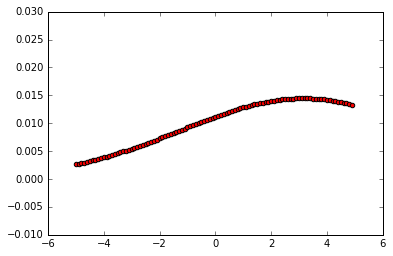

In [24]:
# ps = params
ps = r.retrieve(('principal','dictator'))
res = Resolution(5.0,50)

# qud = sorted(ps.quds).index("effective")
# _,_,_ = visualize(ps,qud,res,'red')
# print("QUD:",ps.quds[qud])
print(sorted(list(zip(sorted(ps.quds),ps.qud_marginals)),key=lambda x:x[1],reverse=True))

# for i in range(len(ps.quds)):
#     if i > 0: _,_,_ = visualize(params,i,res,'red')
    
qud = 0
print("QUD",sorted(ps.quds)[qud])
_,_,_ = visualize(ps,qud,res,'red')

#PRIOR
# vals = scipy.stats.multivariate_normal.pdf(np.arange(-res.size,res.size)*res.amount,mean=params.subspace_prior_means[line][0],cov=5.0)
# hm = matplotlib.pyplot.scatter(c='yellow',x=np.arange(-res.size,res.size)*res.amount,y=vals)


In [2]:
from __future__ import division
from collections import defaultdict
import scipy
import numpy as np
import pickle
import itertools
from dist_rsa.dbm import *
from dist_rsa.utils.load_data import *
from dist_rsa.utils.helperfunctions import *
from dist_rsa.utils.config import abstract_threshold,concrete_threshold
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from dist_rsa.utils.simple_vecs import real_vecs as simple_vecs
import itertools
from dist_rsa.dbm import Resolution




def l1_model(subj,pred,sig1,sig2,l1_sig1,quds,possible_utterances):
    vec_size,vec_kind = 25,'glove.twitter.27B.'

    vecs = simple_vecs
    real_vecs= simple_vecs

    print("UTTERANCES:\n",sorted(list(set(possible_utterances).union(set([pred]))))[:20])

    params = Inference_Params(
        vecs=real_vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=sorted(list(set(possible_utterances).union(set([pred])))),
        sig1=sig1,sig2=sig2, l1_sig1=l1_sig1,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_mixture",
        heatmap=True,
        calculate_projected_marginal_world_posterior=True,
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)
    tf_results = run.tf_results
    return tf_results,params

if __name__ == "__main__":

    results,params = l1_model(subj="man",pred="swimmer",sig1=5.0,sig2=0.5,l1_sig1=5.0,quds=["vicious","swims"],possible_utterances=["shark","swimmer","man"])


/home/rcohngordon/dist-rsa/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


UTTERANCES:
 ['man', 'shark', 'swimmer']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['man']
predicate swimmer
SIGs 1&2: 5.0 0.5
L1 SIG 5.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_mixture RSA with 3 possible utterances and 2
RUNNING DISCRETE MIXTURE MODEL


  0%|          | 0/2 [00:00<?, ?it/s]

qud_combinations 2 [['swims'], ['vicious']]
quds 2
SIZE,AMOUNT 100 0.1
CURRENT QUD: ['swims']


 50%|█████     | 1/2 [00:02<00:02,  2.82s/it]

(2, 2, 4)
(2, 2, 3, 4)
CURRENT QUD: ['vicious']


100%|██████████| 2/2 [00:05<00:00,  2.55s/it]


time: 5.102152109146118
time: 0.9972281455993652
HEATMAP MEAN [ 0.78636926 -0.8239161 ]
time: 17.75559401512146


[[ 0.         1.9503281]
 [-1.3615758  0.       ]]
[0.42244858 0.5775515 ]
[[ 0.          0.82391334]
 [-0.7863802   0.        ]]
x 0.0
y 1.9503283528204471


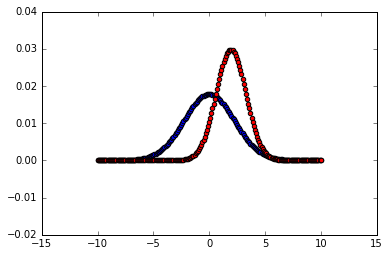

In [28]:
# hm_vals = np.flip(np.flip(params.heatmaps[1],axis=0),axis=1)
print(params.means)
print(params.qud_marginals)
print(params.means*np.expand_dims(params.qud_marginals,1))
# worlds = params.heatmaps[1]

# print(np.array_equal(hms,params.heatmaps))
# print(params.qud_marginals)
# raise Exception

# print(results[1])
# print(params.qud_marginals)
# raise Exception


transposed_hms = np.asarray([np.flip(params.heatmaps[0].T,axis=0),np.flip(params.heatmaps[1].T,axis=1)])
# transposed_hms = np.asarray([params.heatmaps[0],params.heatmaps[1]])
worlds = np.sum(transposed_hms*np.reshape(params.qud_marginals,(2,1,1)),axis=0)
worlds = transposed_hms[0]

# worlds = np.flip(params.heatmaps[0].T,axis=0)
# worlds = np.flip(params.heatmaps[1].T,axis=1)

# print(worlds)
# worlds = params.worlds
# raise Exception
hm = matplotlib.pyplot.scatter(c='blue',x=(np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount),y=np.sum(worlds,axis=0))
hm = matplotlib.pyplot.scatter(c='red',x=(np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount),y=np.sum(worlds,axis=1))

x = np.sum(worlds,axis=0)
print("x",np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*x))

y = np.sum(worlds,axis=1)
print("y",np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*y))


marginal mean 0.8239133325170513
prior mean 0.0
cond mean 0.0
cond variance 5.0
marginal mean 0.8239133325170513
prior mean 0.0
cond mean 0.0
cond variance 5.0


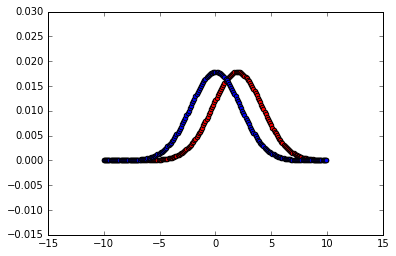

In [33]:
# res = Resolution(5,100)
res = params.resolution
# res.amount=1
# why is yellow and blue the same
# a = visualize(params,1,res,'blue',q=0)
# a = visualize(params,1,res,'red',q=1)
# a = visualize(params,1,res,'yellow',q=None)
# a = visualize(params,0,res,'green',q=None)
a = visualize(params,0,res,'red',q=0)
a = visualize(params,0,res,'blue',q=1)
# visualize(params,1,res,'red',q=1)
# visualize(params,1,res,'blue',q=0)
# visualize(params,1,res,'blue',q=1)
# _,_,_ = visualize(params,1,res,'blue')



#PRIOR
# vals = scipy.stats.multivariate_normal.pdf(np.arange(-res.size,res.size)*res.amount,mean=params.subspace_prior_means[0][0],cov=5.0)
# hm = matplotlib.pyplot.scatter(c='yellow',x=np.arange(-res.size,res.size)*res.amount,y=vals)


In [8]:
from __future__ import division
from collections import defaultdict
import scipy
import numpy as np
import pickle
import itertools
from dist_rsa.dbm import *
from dist_rsa.utils.load_data import *
from dist_rsa.utils.helperfunctions import *
from dist_rsa.utils.config import abstract_threshold,concrete_threshold
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import tensorflow as tf
from dist_rsa.utils.simple_vecs import real_vecs as simple_vecs
import itertools
from dist_rsa.dbm import Resolution




def l1_model(subj,pred,sig1,sig2,l1_sig1,quds,possible_utterances):
    vec_size,vec_kind = 25,'glove.twitter.27B.'

    vecs = simple_vecs
    real_vecs= simple_vecs

    print("UTTERANCES:\n",sorted(list(set(possible_utterances).union(set([pred]))))[:20])

    params = Inference_Params(
        vecs=real_vecs,
        subject=[subj],predicate=pred,
        quds=quds,
        possible_utterances=sorted(list(set(possible_utterances).union(set([pred])))),
        sig1=sig1,sig2=sig2, l1_sig1=l1_sig1,
        qud_weight=0.0,freq_weight=0.0,
        number_of_qud_dimensions=1,
        poss_utt_frequencies=defaultdict(lambda:1),
        qud_frequencies=defaultdict(lambda:1),
        rationality=1.0,
        norm_vectors=False,
        resolution=Resolution(span=10,number=100),
        model_type="discrete_exact",
        heatmap=True
        )

    run = Dist_RSA_Inference(params)
    run.compute_l1(load=0,save=False)
    tf_results = run.tf_results
    return tf_results,params

if __name__ == "__main__":

    results,params = l1_model(subj="man",pred="swimmer",sig1=5.0,sig2=0.5,l1_sig1=5.0,quds=["vicious","swims"],possible_utterances=["shark","swimmer","man"])


UTTERANCES:
 ['man', 'shark', 'swimmer']
RESOLUTION. SIZE: 100 AMOUNT: 0.1
subject: ['man']
predicate swimmer
SIGs 1&2: 5.0 0.5
L1 SIG 5.0
number of qud dimensions: 1
rationality: 1.0
Running discrete_exact RSA with 3 possible utterances and 2
RUNNING DISCRETE EXACT MODEL
QUDS: [['swims'], ['vicious']]
sum should be unit 0.9999997
MEAN [-0.7909157   0.81742287]


-0.7908981402030009
-0.8174242649214138


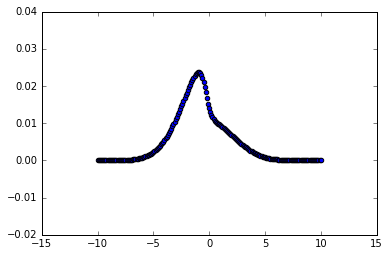

In [10]:
hm_vals = results[0]
# *np.expand_dims(params.qud_marginals,1)
# y=np.sum(hm_vals,axis=1)
# x=(np.arange(-params.resolution.size,params.resolution.size)*params.resolution.amount)
# print(x.shape,y.shape)
hm = matplotlib.pyplot.scatter(c='blue',x=(np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount),y=np.sum(hm_vals,axis=0))
# print((hm_vals))
y = np.sum(hm_vals,axis=1)
print(np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*y))
x = np.sum(hm_vals,axis=0)
print(np.sum((np.arange(-params.resolution.size, params.resolution.size+1)*params.resolution.amount)*x))